# GPU-Accelerated Land Use Land Cover Classification

Working with satellite imagery at scale quickly exposes the limitations of CPU-bound workflows. A single Sentinel-2 tile spans gigabytes and assembling a season’s worth of acquisitions means streaming dozens of those tiles, masking pixels covered by clouds, and compositing them before you can even think about training a model. Processing data of such scale on CPUs means hours of preprocessing before training, making GPUs an attractive solution to accelerate the workflow.
 
Due to the parallel nature of satellite data, GPUs offer tremendous acceleration in every stage of a machine learning workflow. RAPIDS libraries like [cuDF](https://docs.rapids.ai/api/cudf/stable/) and [cuML](https://docs.rapids.ai/api/cuml/stable/) with the help of other libraries like [Dask](https://www.dask.org/) and [Xarray](https://docs.xarray.dev/en/stable/) map operations to CUDA kernels, so resampling, feature derivation, and tree training execute across thousands of cores at once. By loading data into GPU memory and keeping subsequent transformations local to the GPU, we avoid the I/O overhead of shuffling data between the GPU and local memory and thus sustain the throughput needed for year-scale land-cover modelling.

This notebook establishes a end-to-end workflow to train a classification model on satellite imagery. We start by streaming Sentinel-2 imagery from [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) into a [Dask-CUDA](https://docs.rapids.ai/api/dask-cuda/stable/) cluster, using Dask/CuPy backed xarray to clean and aggregate the rasters. We then keep the data on device to train a cuML random forest and finish by writing predictions straight back to Cloud-Optimized GeoTIFFs, ready for validation and sharing.

For this workflow, we use two open and freely available data sources as features and labels, downloaded from Microsoft Planetary Computer. [Sentinel-2 Level-2A](https://dataspace.copernicus.eu/data-collections/copernicus-sentinel-data/sentinel-2) imagery supplies 10 m multispectral observations (B02, B03, B04, B08 are the 10 metre bands that correspond to blue, green, red and near-infrared wavelengths) annually with a 5 day revisit frequency, which we condense into cloud-free yearly composites and enrich with indices like NDVI and NDWI for the year 2022. [ESA WorldCover](https://esa-worldcover.org/en) provides annual 10 m land-cover labels, with its 2023 release reflecting the landscape from 2022, giving us labels for supervised training. Together they provide the coverage and scale to illustrate the benefits of using GPUs for this task.

The machine learning use case illustrated in this notebook, Land use and land cover (LULC) classification, is the task of labelling each pixel in an image according to the surface type it represents. Typical labels include water, trees, crops, built areas, bare ground, and rangeland. These maps help planners monitor urban growth, estimate crop acreage, or track ecosystem change.

### Prerequisites
- Access to an NVIDIA GPU (preferably multiple GPUs) with CUDA, RAPIDS, Dask, and the other libraries imported below.
- A GeoJSON that defines your area of interest (AOI) and access to Microsoft Planetary Computer for Sentinel-2 and ESA WorldCover assets.
- Optional: access to write Cloud-Optimized GeoTIFFs to your target S3 bucket.

In [ ]:
import dataclasses
import json
import pickle
from pathlib import Path

import boto3
import cudf
import cupy as cp
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer
import pyproj
import rasterio
import seaborn as sns
import stackstac
import xarray as xr
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import accuracy_score
from dask.distributed import Client as DaskClient
from dask.distributed import progress, wait
from dask_cuda import LocalCUDACluster
from matplotlib.colors import BoundaryNorm, ListedColormap
from pystac_client import Client
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
from shapely.ops import transform
from sklearn.metrics import classification_report, confusion_matrix
from stackstac.raster_spec import RasterSpec

## Stage 1 · Ingest and Prepare Training Data

We begin by getting the raw ingredients into GPU-friendly form. That means streaming Sentinel-2 scenes and WorldCover labels straight from the Planetary Computer, reprojecting them onto a common grid, and reshaping them into chunk sizes that Dask can scatter across every GPU. The goal is to build clean yearly composites and companion label layers once, persist them as [Zarr](https://zarr.dev/) stores, and avoid recomputing expensive preprocessing later in the notebook.

### 1. Set Workspace Paths and Parameters

Run this cell to lock in the project-wide constants the pipeline needs: where to find your AOI GeoJSON, which Sentinel-2 bands and WorldCover assets to request, how to chunk raster stacks, and where to stage intermediate outputs. Update the paths and `S3_BUCKET`/`S3_PREFIX` now so the rest of the notebook writes to the right locations. Confirm the directories exist (the code creates any missing output folders for you) and keep the date range and cloud filter aligned with the scenes you plan to process.

In this example, we are using an area of interest of 1209 sqKM over the Boston Metropolitan area from 2022 as the bounds for the training data. 

In [ ]:
AOI_GEOJSON = Path("<path to your AOI GeoJSON file>")
FEATURES_ZARR = Path("<desired path for the features zarr store>")
MODEL_PATH = Path("<desired path for the model file>")
INFERENCE_OUTPUT_DIR = Path("<desired path for the inference output directory>")
AWS_REGION = "<your AWS region>"
S3_BUCKET = "<your S3 bucket name>"
S3_PREFIX = "lulc"
MODEL_PATH = Path("<path to your model file ending with .pkl>")
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

In [ ]:
# General configuration / outputs
DATE_RANGE = ("2022-01-01", "2022-12-31")
MAX_CLOUD_FILTER = (
    50  # Set this value higher to fetch more scenes with higher cloud cover
)
S2_ASSETS = ["B02", "B03", "B04", "B08", "SCL"]

TARGET_RESOLUTION = 10
STACK_CHUNKS = {"time": 1, "band": 1, "y": 2048, "x": 2048}

WORLDCOVER_COLLECTION = "io-lulc-annual-v02"
WORLDCOVER_ASSET = "data"

FEATURES_ZARR.mkdir(parents=True, exist_ok=True)
INFERENCE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

CATALOG_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"

BANDS = ["B02", "B03", "B04", "B08"]
ALL_FEATURES = ["B02", "B03", "B04", "B08", "NDVI", "NDWI"]
NODATA_VALUE = 0
VALID_CLASSES = [1, 2, 4, 5, 7, 8, 11]

COG_PROFILE = cog_profiles.get("deflate")
s3_client = boto3.client("s3", region_name=AWS_REGION)

### 2. Launch a Dask-CUDA Cluster

Start the local Dask-CUDA cluster now so every downstream step can submit GPU workloads through the distributed client. Run this cell and confirm the dashboard link appears. If you need to pin workers to specific GPUs or change memory limits, modify the arguments for `LocalCUDACluster` before proceeding.

In [ ]:
cluster = LocalCUDACluster()
client = DaskClient(cluster)
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 503.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43293,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46357,Total threads: 1
Dashboard: http://127.0.0.1:40133/status,Memory: 62.97 GiB
Nanny: tcp://127.0.0.1:35431,


### 3. Load and Reproject the Area of Interest

Use this cell to validate and prepare your AOI geometry. It reads the GeoJSON configured earlier, checks that a CRS is declared, merges all features into one geometry, and chooses an appropriate UTM zone based on the centroid. Run it once to produce `aoi_geom`, its projected bounds, and a GeoJSON payload that the STAC search will reuse. If your AOI spans multiple UTM zones, replace the automated EPSG selection with the desired one before executing.

To create an AOI in GeoJSON format by drawing polygons over a map in an interactive way, you can use the [geojson.io](https://geojson.io/#map=2/0/20) website.

In [ ]:
aoi_gdf = gpd.read_file(AOI_GEOJSON)
if aoi_gdf.crs is None:
    raise ValueError("AOI GeoJSON must declare a CRS.")

aoi_geom = aoi_gdf.geometry.union_all()

# choose UTM zone from AOI centroid
centroid = aoi_geom.centroid
utm_zone = int((centroid.x + 180) // 6) + 1
target_epsg = (
    int(f"326{utm_zone:02d}") if centroid.y >= 0 else int(f"327{utm_zone:02d}")
)

aoi_geom_geojson = json.loads(gpd.GeoSeries([aoi_geom]).to_json())["features"][0][
    "geometry"
]

project = pyproj.Transformer.from_crs(4326, target_epsg, always_xy=True).transform
aoi_geom_proj = transform(project, aoi_geom)
aoi_bounds = tuple(aoi_geom_proj.bounds)

In [5]:
print(aoi_bounds)
print(target_epsg)
print(aoi_geom_geojson)

(305317.1002981191, 4672613.712909488, 337897.39514006017, 4709696.839024326)
32619
{'type': 'Polygon', 'coordinates': [[[-71.35765504252703, 42.515400835973594], [-71.35765504252703, 42.18871065844891], [-70.97331384909891, 42.18871065844891], [-70.97331384909891, 42.515400835973594], [-71.35765504252703, 42.515400835973594]]]}


### 4. Fetch Sentinel-2 tiles for the AOI

Search the Planetary Computer STAC API for Sentinel-2 Level-2A scenes that overlap your AOI, match the configured date window, and meet the cloud threshold. Run this cell to pull the items, guard against empty results, and build a lazily-loaded raster stack with `stackstac`. The stack is clipped to your AOI bounds, resampled to the target resolution and chunked for GPU friendly processing. 

In [ ]:
stac = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = stac.search(
    collections=["sentinel-2-l2a"],
    intersects=aoi_geom_geojson,
    datetime=f"{DATE_RANGE[0]}/{DATE_RANGE[1]}",
    query={"eo:cloud_cover": {"lt": MAX_CLOUD_FILTER}},
)

items = list(search.items())
if not items:
    raise ValueError("No Sentinel-2 scenes found for AOI/year.")

stack = (
    stackstac.stack(
        items,
        assets=S2_ASSETS,
        bounds=aoi_bounds,
        resolution=TARGET_RESOLUTION,
        epsg=target_epsg,
        chunksize=(200, 1, 1024, 1024),
        fill_value=np.nan,
        rescale=False,
        properties=["datetime"],
    )
    .astype("float32")
    .sortby("time")
    .persist()
)

stack = stack.assign_coords(band=S2_ASSETS[: stack.sizes["band"]])
stack

<xarray.DataArray 'stackstac-ab76180e80abf176f2f32addab78855e' (time: 419,
                                                                band: 5,
                                                                y: 3709, x: 3259)> Size: 101GB
dask.array<getitem, shape=(419, 5, 3709, 3259), dtype=float32, chunksize=(200, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time                 (time) datetime64[ns] 3kB 2022-01-04T15:36:41.024000...
  * band                 (band) <U3 60B 'B02' 'B03' 'B04' 'B08' 'SCL'
  * y                    (y) float64 30kB 4.71e+06 4.71e+06 ... 4.673e+06
  * x                    (x) float64 26kB 3.053e+05 3.053e+05 ... 3.379e+05
    id                   (time) <U54 91kB 'S2A_MSIL2A_20220104T153641_R111_T1...
    title                (band) <U29 580B 'Band 2 - Blue - 10m' ... 'Scene cl...
    gsd                  (band) float64 40B 10.0 10.0 10.0 10.0 20.0
    common_name          (band) object 40B 'blue' 'green' 'red' 'nir' None
    center_wavelength    (band) object 40B 0.49 0.56 0.665 0.842 None
    full_width_half_max  (band) object 40B 0.098 0.045 0.038 0.145 None
    epsg                 int64 8B 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(305310, 4672610, 337900, 4709...
    crs:         epsg:32619
    transform:   | 10.00, 0.00, 305310.00|\n| 0.00,-10.00, 4709700.00|\n| 0.0...
    resolution:  10

In [ ]:
progress([stack])

Persisting the stack up front forces Dask to scatter chunks across every available GPU before we start feature engineering. If we wait until the first compute call, the scheduler will add most of the chunks onto a single worker to prevent shuffle overhead, which in turn runs the risk of running out of memory. By persisting the data now onto the GPU memory, we keep the data evenly distributed for the rest of the pipeline.

### 5. Prepare Daily Spectral Composites

Satellite imagery is usually captured in the form of tiles, a specific image captured by the satellite corresponding to a certain area, specified in the tile extent. In the previous step, we captured all the tiles that intersect with our AOI for all dates in 2022. However, there might be multiple tiles that intersect with our AOI captured on a specific date. These tiles also occasionally do intersect in area, so before calculating an annual median value for each pixel, we group this data by unique capture dates and use the median value for band-wise reflectance where tiles overlap.

Sentinel-2 tiles also include a special band called the Sentinel-2 Scene Classification Layer (SCL), which tags each pixel with a surface or atmospheric class inferred from the Level-2A processing chain. It distinguishes nodata (0), saturated or defective pixels (1), dark areas (2), cloud shadow (3), vegetation (4), bare soils (5), water (6), cloud probabilities from low to high (7–9), thin cirrus (10), and snow or ice (11). Using SCL lets you mask out cloudy or otherwise unreliable observations before aggregating daily composites, so only the clear-sky land pixels (classes 4–6 and 11) contribute to the summaries.

In the following steps, we assign a daily date coordinate, split out the Sentinel-2 [Scene Classification Layer](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/)(`SCL`), and keep only the spectral bands used for features. We then apply the clear-sky mask (classes 3, 4, 5, 6, 11) so cloudy pixels become `NaN`, then group by day mosaic acquisitions on the same day. Run this cell to define the lazy Dask graph for daily composites; no computation occurs yet.

In [ ]:
dates = stack["time"].dt.floor("D").values
stack = stack.assign_coords(date=("time", dates))

scl = stack.sel(band="SCL")
spectral = stack.drop_sel(band="SCL")

clear = scl.isin([3, 4, 5, 6, 11])
spectral = spectral.where(clear, np.nan)

daily_stack = spectral.groupby("date").median(dim="time", skipna=True)
daily_stack

<xarray.DataArray 'stackstac-ab76180e80abf176f2f32addab78855e' (date: 80,
                                                                band: 4,
                                                                y: 3709, x: 3259)> Size: 15GB
dask.array<stack, shape=(80, 4, 3709, 3259), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * date     (date) datetime64[ns] 640B 2022-01-04 2022-01-22 ... 2022-12-30
  * band     (band) <U3 48B 'B02' 'B03' 'B04' 'B08'
  * y        (y) float64 30kB 4.71e+06 4.71e+06 4.71e+06 ... 4.673e+06 4.673e+06
  * x        (x) float64 26kB 3.053e+05 3.053e+05 ... 3.379e+05 3.379e+05
    epsg     int64 8B 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(305310, 4672610, 337900, 4709...
    crs:         epsg:32619
    transform:   | 10.00, 0.00, 305310.00|\n| 0.00,-10.00, 4709700.00|\n| 0.0...
    resolution:  10

### 6. Rechunk Daily Composites for GPU Throughput

Adjust the chunk structure before any heavy computation runs. This cell groups dates in batches of 10, limits each task to two bands, and uses 1,024×1,024 pixels in the spatial dimension so Dask can stream work evenly across GPUs without each chunk being too small. Run it once to update the delayed graph. No data is computed yet, but downstream feature calculations will inherit this layout.

In [9]:
daily_stack = daily_stack.chunk({"date": 10, "band": 2, "y": 1024, "x": 1024})
daily_stack

<xarray.DataArray 'stackstac-ab76180e80abf176f2f32addab78855e' (date: 80,
                                                                band: 4,
                                                                y: 3709, x: 3259)> Size: 15GB
dask.array<rechunk-merge, shape=(80, 4, 3709, 3259), dtype=float32, chunksize=(10, 2, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * date     (date) datetime64[ns] 640B 2022-01-04 2022-01-22 ... 2022-12-30
  * band     (band) <U3 48B 'B02' 'B03' 'B04' 'B08'
  * y        (y) float64 30kB 4.71e+06 4.71e+06 4.71e+06 ... 4.673e+06 4.673e+06
  * x        (x) float64 26kB 3.053e+05 3.053e+05 ... 3.379e+05 3.379e+05
    epsg     int64 8B 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(305310, 4672610, 337900, 4709...
    crs:         epsg:32619
    transform:   | 10.00, 0.00, 305310.00|\n| 0.00,-10.00, 4709700.00|\n| 0.0...
    resolution:  10

### 7. Aggregate by Year and Engineer Spectral Indices

With daily composites defined, run this cell to collapse each pixel into an annual median and derive GPU-friendly features. The next cell stamps a `year` coordinate, groups by year to reduce seasonal noise, and then computes `NDVI` and `NDWI` alongside the raw bands. The dataset is rechunked so each task covers one year, two bands, and 1,024×1,024 tiles, matching the earlier layout and keeping downstream sampling efficient. Execution remains lazy here; you will trigger compute later when you materialize training data.

**Notes on the spectral indices**

- `NDVI = (NIR − Red) / (NIR + Red)` gauges vegetation vigor. High values indicate dense photosynthetically active biomass, while bare ground or urban areas trend toward zero or negative.
- `NDWI = (Green − NIR) / (Green + NIR)` emphasizes surface water and moist vegetation. Positive values mark water bodies or saturated soils, whereas dry ground returns negatives.

In [10]:
daily_stack = daily_stack.assign_coords(
    year=("date", pd.DatetimeIndex(daily_stack["date"].values).year)
)
yearly_stack = daily_stack.groupby("year").median(dim="date", skipna=True)

red = yearly_stack.sel(band="B04")
nir = yearly_stack.sel(band="B08")
green = yearly_stack.sel(band="B03")

feature_ds = xr.Dataset(
    {
        "bands": yearly_stack,
        "NDVI": (nir - red) / (nir + red),
        "NDWI": (green - nir) / (green + nir),
    }
)

feature_ds = feature_ds.chunk({"year": 1, "band": 2, "y": 1024, "x": 1024})
feature_ds

<xarray.Dataset> Size: 290MB
Dimensions:  (x: 3259, y: 3709, band: 4, year: 1)
Coordinates:
  * x        (x) float64 26kB 3.053e+05 3.053e+05 ... 3.379e+05 3.379e+05
  * y        (y) float64 30kB 4.71e+06 4.71e+06 4.71e+06 ... 4.673e+06 4.673e+06
  * band     (band) <U3 48B 'B02' 'B03' 'B04' 'B08'
  * year     (year) int32 4B 2022
    epsg     int64 8B 32619
Data variables:
    bands    (year, band, y, x) float32 193MB dask.array<chunksize=(1, 2, 1024, 1024), meta=np.ndarray>
    NDVI     (year, y, x) float32 48MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    NDWI     (year, y, x) float32 48MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

### 8. Retrieve and Distribute WorldCover Labels

Search the Planetary Computer catalogue for ESA WorldCover tiles that intersect the AOI and cover the year 2023. ESA publishes each annual WorldCover release on January 1 to describe the land cover of the preceding year, so the 2023 layer is the right match for the 2022 imagery we processed above. Run this cell to download the overlapping items, guard against empty results, and build a raster stack that matches your AOI bounds, resolution, and projection. As with the imagery, `persist()` spreads the label blocks across GPUs right away so later sampling and joins avoid a single-worker bottleneck. 

In [11]:
label_items = list(
    stac.search(
        collections=[WORLDCOVER_COLLECTION],
        intersects=aoi_geom_geojson,
        datetime="2023-01-01/2023-12-31",
    ).items()
)
if not label_items:
    raise ValueError("No WorldCover tiles overlap the AOI/year.")

label_stack = (
    stackstac.stack(
        label_items,
        assets=[WORLDCOVER_ASSET],
        bounds=aoi_bounds,
        resolution=TARGET_RESOLUTION,
        epsg=target_epsg,
        chunksize=(1, 1, 1024, 1024),
        rescale=False,
        fill_value=np.nan,
    )
    .astype("float32")
    .persist()
)

label_stack = label_stack.assign_coords(band=["map"])
label_stack

<xarray.DataArray 'stackstac-ead6cc158ddd382facfec575f45bff0e' (time: 2,
                                                                band: 1,
                                                                y: 3709, x: 3259)> Size: 97MB
dask.array<astype, shape=(2, 1, 3709, 3259), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * time             (time) datetime64[ns] 16B NaT NaT
  * band             (band) <U3 12B 'map'
  * y                (y) float64 30kB 4.71e+06 4.71e+06 ... 4.673e+06 4.673e+06
  * x                (x) float64 26kB 3.053e+05 3.053e+05 ... 3.379e+05
    id               (time) <U8 64B '19T-2023' '19T-2022'
    proj:transform   object 8B {0.0, 243910.0, 5320650.0, 10.0, -10.0}
    ...               ...
    supercell        (time) object 16B '19T' None
    proj:code        <U10 40B 'EPSG:32619'
    proj:bbox        object 8B {4427760.0, 5320650.0, 243910.0, 756090.0}
    io:supercell_id  (time) object 16B None '19T'
    raster:bands     object 8B {'nodata': 0, 'spatial_resolution': 10}
    epsg             int64 8B 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(305310, 4672610, 337900, 4709...
    crs:         epsg:32619
    transform:   | 10.00, 0.00, 305310.00|\n| 0.00,-10.00, 4709700.00|\n| 0.0...
    resolution:  10

### 9. Align the Label Mosaic with Feature Grids

Collapse the WorldCover stack into a single mosaic, reproject it to the same grid as the feature rasters, and expand it into a year-aligned cube. Run this cell after the data is persisted in the previous cell so the label mosaic matches the band layout and spatial axes of your feature dataset. The result is a `labels_cube` with one layer per feature year, ready to be matched to the Sentinel-2 data.

In [12]:
label_mosaic = stackstac.mosaic(label_stack, dim="time").squeeze("band", drop=True)

template = feature_ds["bands"].sel(year=feature_ds.year[0], band="B02")
label_mosaic = label_mosaic.rio.reproject_match(
    template, resampling=rasterio.enums.Resampling.nearest
)

labels_cube = xr.DataArray(
    label_mosaic.values[None, :, :],
    dims=("year", "y", "x"),
    coords={"year": feature_ds.year, "y": label_mosaic.y, "x": label_mosaic.x},
    name="worldcover",
)
labels_cube = labels_cube.chunk({"year": 1, "y": 1024, "x": 1024})
labels_cube

<xarray.DataArray 'worldcover' (year: 1, y: 3709, x: 3259)> Size: 48MB
dask.array<xarray-<this-array>, shape=(1, 3709, 3259), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int32 4B 2022
  * y        (y) float64 30kB 4.71e+06 4.71e+06 4.71e+06 ... 4.673e+06 4.673e+06
  * x        (x) float64 26kB 3.053e+05 3.053e+05 ... 3.379e+05 3.379e+05

### 10. Strip JSON Metadata Before Writing to Zarr

Before you write features and labels to Zarr files, sanitize the RasterSpec metadata so it contains only plain Python types. Zarr cannot serialize the nested JSON-like objects that `stackstac` attaches by default, so this utility walks through each variable’s attributes and rewrites any `RasterSpec` entries into dictionaries and tuples the store can handle. Run it once; the cleaned `feature_ds` and `labels_ds` will be ready for disk writes in the next step.

In [13]:
def raster_spec_to_plain(value):
    if isinstance(value, RasterSpec):
        if dataclasses.is_dataclass(value):
            data = dataclasses.asdict(value)
        else:
            data = {}
            for k, v in value.__dict__.items():
                if hasattr(v, "to_gdal"):
                    data[k] = tuple(v)
                elif isinstance(v, tuple):
                    data[k] = list(v)
                else:
                    data[k] = v
        return data
    return value


for var in feature_ds.variables.values():
    var.attrs = {k: raster_spec_to_plain(v) for k, v in var.attrs.items()}

labels_ds = labels_cube.to_dataset(name="worldcover")
for var in labels_ds.variables.values():
    var.attrs = {k: raster_spec_to_plain(v) for k, v in var.attrs.items()}

### 11. Materialize Features and Labels to Zarr

Write the cleaned feature and label cubes to disk now so later stages can reload them without recomputation. This cell enqueues the `.to_zarr()` operations on the Dask cluster (without triggering them locally), hands the futures to the scheduler, and waits for both writes to finish. When it completes, you have consolidated Zarr stores under `FEATURES_ZARR` that store the data computed in the previous steps.

In [ ]:
feature_path = FEATURES_ZARR / "sentinel2_2022_annual.zarr"
labels_path = FEATURES_ZARR / "worldcover_2022_annual.zarr"

feature_future = client.compute(
    feature_ds.to_zarr(
        feature_path,
        consolidated=True,
        mode="w",
        compute=False,
    )
)

labels_future = client.compute(
    labels_cube.to_dataset(name="worldcover").to_zarr(
        labels_path,
        consolidated=True,
        mode="w",
        compute=False,
    )
)

wait([feature_future, labels_future])

## Stage 2 · Train and Evaluate the Model

Now that the data has no cloudy/no-data pixels, composited to an annual median over the entire AOI and stored in Zarr stores, we will focus on training a model for LULC classification. To keep with the theme of using the GPU for all aspects of this workflow, we will use cuML's Random Forest model as the classifier. The following steps focus on loading data from the already prepared Zarr stores using Xarray, filtering relevant label classes from this data, flattening the data and sending the data to the GPU using cupy-xarray and finally training and evaluating the Random Forest model. The trained model is then saved to a pickle file for easy inference. 

### 1. Define Training Targets and Class Metadata

Set the random seed, split ratio, and the WorldCover classes valid after filtering when you reload the data. Adjust `target_year` if you want a different label slice, tweak `train_fraction` to control how many pixels feed the model versus evaluation, and customize the `worldcover_classes` mapping to reflect the categories you plan to predict. 

In this example, we ignore the snow/ice and cloud classes from the `worldcover_classes` variable below as we are calculating an annual median reflectance for each pixel and seasonal/ephermeral features will not be represented appropriately in this training data. Keeping the valid class list here ensures downstream sampling can discard nodata pixels and pixels with labels representing other classes.

In [15]:
target_year = 2022
random_state = 42
train_fraction = 0.8

worldcover_classes = {
    1: "Water",
    2: "Trees",
    4: "Flooded vegetation",
    5: "Crops",
    7: "Built area",
    8: "Bare ground",
    11: "Rangeland",
}
nodata_value = 0
valid_classes = list(worldcover_classes.keys())

### 2. Reload Zarr Stores and Build Feature Stacks

Open the feature and label Zarr stores and gather the bands and indices you need for modeling. Because our data has been reduced to a single annual median for each pixel, we can work on a single GPU now. Using the [cupy-xarray](https://cupy-xarray.readthedocs.io/latest/) library, we convert the Dask-backed Xarrays from the Zarr store into CuPy backed Xarrays. 

In [ ]:
feature_ds = xr.open_zarr(feature_path, consolidated=True, chunks=None).load()
label_ds = xr.open_zarr(labels_path, consolidated=True, chunks=None).load()

spectral = (
    feature_ds["bands"]
    .sel(year=target_year)
    .assign_coords(band=[str(b) for b in feature_ds.band.values])
)
ndvi = feature_ds["NDVI"].sel(year=target_year).expand_dims(band=["NDVI"])
ndwi = feature_ds["NDWI"].sel(year=target_year).expand_dims(band=["NDWI"])

features = xr.concat([spectral, ndvi, ndwi], dim="band")
labels = label_ds["worldcover"].sel(year=target_year)

features = features.cupy.as_cupy()
labels = labels.cupy.as_cupy()

band_names = list(features.band.values)
band_names

['B02', 'B03', 'B04', 'B08', 'NDVI', 'NDWI']

### 3. Spot-Check Feature and Label Rasters

Plot the NDVI, NDWI, and WorldCover layers side by side to make sure the composites and labels look reasonable before sampling. Run this cell to render quicklooks with consistent color ranges for the indices and a discrete palette for the classes. Scan the maps to verify cloud masking, feature contrasts, and class coverage; if something looks off, revisit the preprocessing before training.

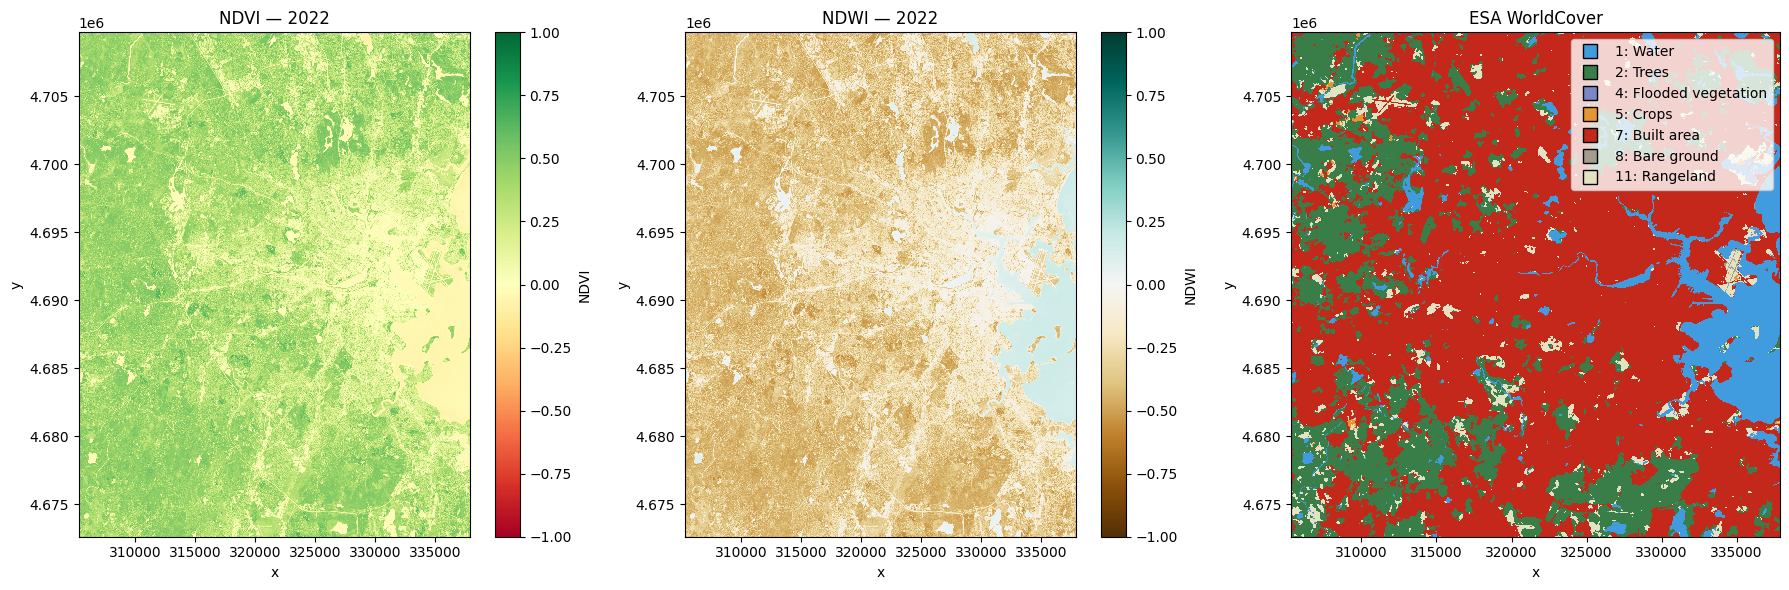

In [ ]:
ndvi_da = feature_ds["NDVI"].sel(year=target_year).squeeze(drop=True)
ndwi_da = feature_ds["NDWI"].sel(year=target_year).squeeze(drop=True)
worldcover_da = label_ds["worldcover"].sel(year=target_year).squeeze(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# NDVI quicklook (values already in [-1, 1])
ndvi_da.plot.imshow(
    ax=axes[0],
    vmin=-1,
    vmax=1,
    cmap="RdYlGn",
    add_colorbar=True,
    cbar_kwargs={"label": "NDVI"},
)
axes[0].set_title(f"NDVI for {target_year}")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

# NDWI quicklook (same range)
ndwi_da.plot.imshow(
    ax=axes[1],
    vmin=-1,
    vmax=1,
    cmap="BrBG",
    add_colorbar=True,
    cbar_kwargs={"label": "NDWI"},
)
axes[1].set_title(f"NDWI for {target_year}")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")

# WorldCover visualization with discrete colors
worldcover_colors = {
    1: "#419bdf",
    2: "#397d49",
    4: "#7a87c6",
    5: "#e49635",
    7: "#c4281b",
    8: "#a59b8f",
    11: "#e3e2c3",
}
classes = list(worldcover_colors.keys())
cmap = ListedColormap([worldcover_colors[k] for k in classes])
norm = BoundaryNorm(classes + [classes[-1] + 1], cmap.N)

worldcover_da.plot.imshow(
    ax=axes[2],
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
)
axes[2].set_title("ESA WorldCover")
axes[2].set_xlabel("x")
axes[2].set_ylabel("y")

# Legend for WorldCover
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="s",
        color="none",
        markerfacecolor=worldcover_colors[k],
        markersize=10,
    )
    for k in classes
]
axes[2].legend(
    handles,
    [f"{k}: {worldcover_classes[k]}" for k in classes],
    loc="upper right",
    frameon=True,
)

plt.tight_layout()
plt.show()

### 3. Filter Valid Pixels and Move Samples to GPU Memory

Run these cells together to filter usable training samples, flatten the rasters into tabular form, and stage the data on the GPU. First, build a mask that requires finite feature values, finite labels, and is a part of our valid class list. Then we apply that mask in place so cloudy or nodata pixels drop out. Next, rasters are stacked into a `(samples × bands)` layout and any rows with missing values are discarded. 

In [ ]:
valid_mask_cp = (
    cp.isfinite(features.data).all(axis=0)
    & cp.isfinite(labels.data)
    & (labels.data != nodata_value)
    & cp.isin(labels.data, cp.asarray(valid_classes))
)

# Broadcast the mask over the band dimension
features_data = cp.where(valid_mask_cp[None, :, :], features.data, cp.nan)
labels_data = cp.where(valid_mask_cp, labels.data, nodata_value)

features = xr.DataArray(
    features_data,
    coords=features.coords,
    dims=features.dims,
    name=features.name,
)

labels = xr.DataArray(
    labels_data,
    coords=labels.coords,
    dims=labels.dims,
    name=labels.name,
)

In [ ]:
stacked_features = features.stack(sample=("y", "x")).transpose("sample", "band")
stacked_labels = labels.stack(sample=("y", "x"))

flat_features = stacked_features.data.astype(cp.float32, copy=False)
flat_labels = stacked_labels.data.astype(cp.int32, copy=False)

valid_rows = cp.isfinite(flat_labels)
valid_rows &= cp.isfinite(flat_features).all(axis=1)

flat_features = flat_features[valid_rows]
flat_labels = flat_labels[valid_rows]

### 4. Split Samples and Convert to cuDF Tables

Next we shuffle the GPU-resident samples with the configured random seed, carve out the training/test split, and wrap the arrays in cuDF structures. Run these two cells to partition the CuPy features and labels according to `train_fraction`, then convert each subset into cuDF DataFrames and Series labeled with the band names. cuML estimators consume these cuDF objects directly, so you’re ready to fit the model next.

In [ ]:
num_samples = flat_features.shape[0]
perm = cp.random.RandomState(random_state).permutation(num_samples)

train_size = int(train_fraction * num_samples)
train_idx = perm[:train_size]
test_idx = perm[train_size:]

X_train_cp = flat_features[train_idx]
y_train_cp = flat_labels[train_idx]
X_test_cp = flat_features[test_idx]
y_test_cp = flat_labels[test_idx]

In [22]:
X_train_cudf = cudf.DataFrame(X_train_cp, columns=band_names)
y_train_cudf = cudf.Series(y_train_cp, name="worldcover")
X_test_cudf = cudf.DataFrame(X_test_cp, columns=band_names)
y_test_cudf = cudf.Series(y_test_cp, name="worldcover")

### 5. Inspect Class Balance Before Training

Plot the per-class pixel counts for the training and validation splits to confirm you carried enough samples forward for each label. Run this cell to visualize the distributions side by side with annotated totals. 

The strong skew you see here comes from working with a single AOI over an urban area (Boston in this example) in which most pixels fall into the “Built Area” class, which is class 7 on our index. When you broaden the footprint or add a variety of different scenes, other classes accumulate more support to reduce data bias.

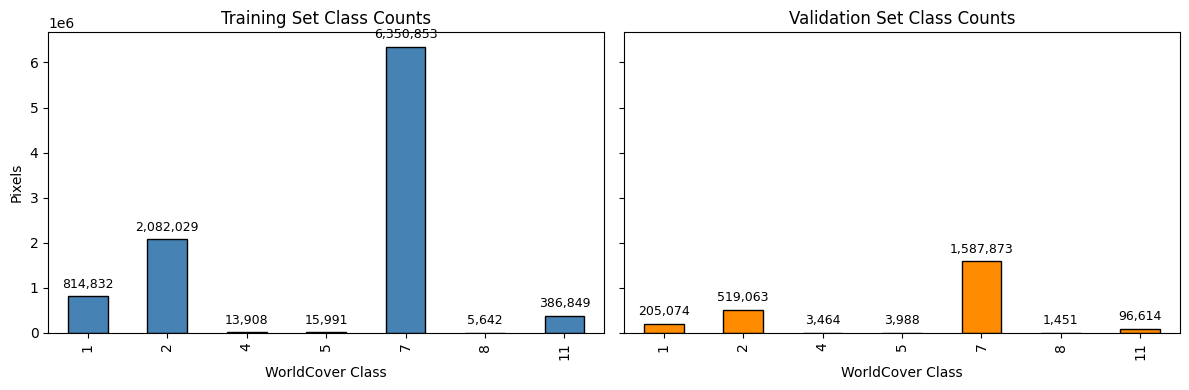

In [23]:
train_counts = y_train_cudf.value_counts().sort_index().to_pandas()
test_counts = y_test_cudf.value_counts().sort_index().to_pandas()

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
train_counts.plot(kind="bar", ax=ax[0], color="steelblue", edgecolor="black")
ax[0].set_title("Training Set Class Counts")
ax[0].set_xlabel("WorldCover Class")
ax[0].set_ylabel("Pixels")

test_counts.plot(kind="bar", ax=ax[1], color="darkorange", edgecolor="black")
ax[1].set_title("Validation Set Class Counts")
ax[1].set_xlabel("WorldCover Class")

# Annotate bars
for axis, counts in zip(ax, [train_counts, test_counts], strict=False):
    for patch, val in zip(axis.patches, counts.values, strict=False):
        axis.annotate(
            f"{int(val):,}",
            (patch.get_x() + patch.get_width() / 2, patch.get_height()),
            ha="center",
            va="bottom",
            fontsize=9,
            xytext=(0, 4),
            textcoords="offset points",
        )

plt.tight_layout()
plt.show()

### 6. Train a cuML Random Forest on the GPU

Instantiate the cuML `RandomForestClassifier` with your chosen tree count, histogram bins, and streams, then fit it on the cuDF training table. Run this cell to launch GPU-accelerated training; the estimator consumes the cuDF inputs directly and keeps the model resident on device for rapid evaluation in the following steps.

In [24]:
rf = RandomForestClassifier(
    n_estimators=300,
    n_bins=256,
    n_streams=4,
    bootstrap=True,
    split_criterion="gini",
    random_state=random_state,
)

rf.fit(X_train_cudf, y_train_cudf)

RandomForestClassifier()

While the model training is in progress, if you want to visualize the system hardware metrics and understand GPU and memory consumption within your Jupyterlab environment, consider using the [NVDashboard](https://github.com/rapidsai/jupyterlab-nvdashboard) Jupyterlab extension.

### 7. Score the Model and Build a Confusion Matrix

Evaluate the trained forest on the validation split by predicting in GPU memory and computing accuracy with cuML. Convert the predictions to Pandas dataframes for diagnostics, then build a confusion matrix aligned with your class list. Run this cell to print the headline accuracy and produce an `xarray.DataArray` you can visualize in the next step.

In [25]:
pred_gpu = rf.predict(X_test_cudf)

val_acc = accuracy_score(y_test_cudf, pred_gpu)
print(f"Validation accuracy: {val_acc:.3f}")

pred_cpu = pred_gpu.to_pandas()
test_cpu = y_test_cudf.to_pandas()

cm = confusion_matrix(test_cpu, pred_cpu, labels=valid_classes)
cm_da = xr.DataArray(
    cm,
    coords={"actual": valid_classes, "predicted": valid_classes},
    dims=("actual", "predicted"),
)
cm_da

Validation accuracy: 0.799


<xarray.DataArray (actual: 7, predicted: 7)> Size: 392B
array([[ 184927,    2715,       0,       0,   17263,       0,     169],
       [   1348,  320945,       0,       0,  195357,       0,    1413],
       [    108,      54,       0,       0,    3122,       0,     180],
       [      6,      27,       0,       0,    3749,       0,     206],
       [   4652,  170411,       0,       0, 1400861,       0,   11949],
       [      0,       0,       0,       0,    1451,       0,       0],
       [    136,    3933,       0,       0,   68015,       0,   24530]])
Coordinates:
  * actual     (actual) int64 56B 1 2 4 5 7 8 11
  * predicted  (predicted) int64 56B 1 2 4 5 7 8 11

### 8. Visualize Confusion Matrix and Interpret Class Coverage

Plot the confusion matrix to see where the model succeeds and where the sparse classes fall short. Run this cell to render the heatmap.

::::{note}
Note how the undersampled types (flooded vegetation, bare ground) attract almost no predicted pixels. That’s a direct consequence of the skewed training data; expand the AOI or add more scenes when you need reliable performance on those categories.
::::

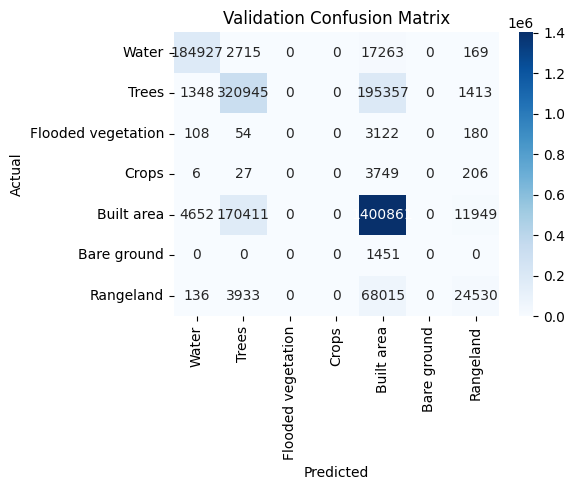

In [26]:
cm = confusion_matrix(test_cpu, pred_cpu, labels=valid_classes)
labels_pretty = [worldcover_classes[c] for c in valid_classes]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels_pretty,
    yticklabels=labels_pretty,
)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### 9. Review Precision/Recall by Class

Summarize model performance with per-class precision and recall. Run this cell to chart the scores; it highlights that classes without any predicted pixels (flooded vegetation, crops, bare ground) drop to zero precision and recall. Use this metric to identify subclasses that need more samples to balance the dataset

/raid/jjayabaskar/gis12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/raid/jjayabaskar/gis12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/raid/jjayabaskar/gis12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

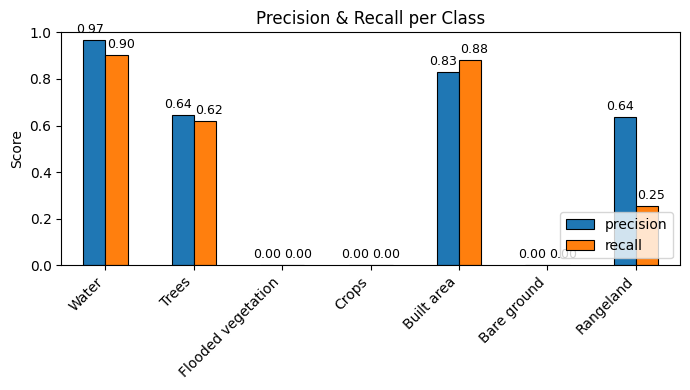

In [27]:
report = classification_report(
    test_cpu,
    pred_cpu,
    labels=valid_classes,
    output_dict=True,
)
pr_table = pd.DataFrame(report).loc[["precision", "recall"], map(str, valid_classes)].T
pr_table.index = labels_pretty

ax = pr_table.plot(kind="bar", linewidth=0.8, edgecolor="black", figsize=(7, 4))
ax.set_title("Precision & Recall per Class")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.set_xticklabels(labels_pretty, rotation=45, ha="right")
ax.legend(loc="lower right")

for i, container in enumerate(ax.containers):
    shift = -0.05 if i == 0 else 0.05  # adjust per container
    for patch, val in zip(container.patches, container.datavalues, strict=False):
        ax.annotate(
            f"{val:.2f}",
            (
                patch.get_x() + patch.get_width() / 2 + shift,
                patch.get_height(),
            ),
            ha="center",
            va="bottom",
            fontsize=9,
            xytext=(0, 3),
            textcoords="offset points",
        )

plt.tight_layout()
plt.show()

### 10. Persist the Trained Model

Save the fitted Random Forest so you can reload it for inference. Run this cell to create the model directory if needed and pickle the cuML estimator. Keeping a serialized copy lets you deploy predictions without retraining or rerunning the feature pipeline.

In [ ]:
with open(str(MODEL_PATH), "wb") as f:
    pickle.dump(rf, f)

## Stage 3 · Run Inference and Publish the classification tile

Now that we have finished training the model, in this stage we load the saved Random Forest model, pull a fresh Sentinel-2 tile, compute the familiar spectral features on the GPU, and classify each pixel. After reshaping the predictions into a raster, we compare them against the tile’s true-color composite to compare the two, then write the result to a Cloud-Optimized GeoTIFF (locally or to S3).

### 1. Reload the Trained Model

Start by bringing the serialized Random Forest back into memory. Run this cell to unpickle the estimator you saved in Stage 2; the returned object keeps its GPU parameters and is ready to score new tiles without retraining.

In [ ]:
with open(str(MODEL_PATH), "rb") as f:
    rf = pickle.load(f)
rf

RandomForestClassifier()

### 2. Locate the Sentinel-2 Tile to Score

Connect to the Planetary Computer STAC endpoint, supply the Sentinel-2 tile ID you want to score, and stage the COG output path. 

This example targets `S2B_MSIL2A_20251102T154319_R011_T18TWL_20251102T193858`, a Sentinel-2 tile captured over New York in 2025, so you can inspect the model on unseen data. Run these cells to verify the tile exists and fetch its STAC item before you start feature extraction.

In [5]:
client = Client.open(CATALOG_URL, modifier=planetary_computer.sign_inplace)

tile_id = "S2B_MSIL2A_20251102T154319_R011_T18TWL_20251102T193858"  # replace as needed
UPLOAD_TO_S3 = False
cog_path = INFERENCE_OUTPUT_DIR / f"lulc_{tile_id}.tif"

In [6]:
search = client.search(
    collections=["sentinel-2-l2a"],
    ids=[tile_id],
)
items = list(search.items())
if not items:
    raise ValueError(f"No Sentinel-2 L2A items found for '{tile_id}'")

item = items[0]
item

<Item id=S2B_MSIL2A_20251102T154319_R011_T18TWL_20251102T193858>

### 3. Fetch and Stack the Target Tile

Derive the tile’s EPSG code from the STAC metadata, then build a `stackstac` raster for the bands the model expects. Run this cell to fetch the single-scene cube (one time slice, four spectral bands) at 10 m resolution with 2,048×2,048 chunks. Any missing metadata raises an error so you can choose another tile. The result is ready for GPU feature engineering and matches the training band order.

In [7]:
epsg_code = item.properties.get("proj:epsg")
if epsg_code is None:
    proj_code = item.properties.get("proj:code")
    if proj_code:
        epsg_code = int(proj_code.split(":")[-1])
    else:
        raise ValueError("No proj:epsg/proj:code in item")

stack = (
    stackstac.stack(
        [item],
        assets=BANDS,
        resolution=10,
        epsg=epsg_code,
        fill_value=np.nan,
        chunksize=(1, 1, 2048, 2048),
        rescale=False,
    )
    .squeeze("time")
    .assign_coords(band=BANDS)
    .astype("float32")
)

stack

<xarray.DataArray 'stackstac-283cce0ee50d7420a3d5177f659abff1' (band: 4,
                                                                y: 11118,
                                                                x: 10150)> Size: 2GB
dask.array<astype, shape=(4, 11118, 10150), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates: (12/45)
  * band                                     (band) <U3 48B 'B02' ... 'B08'
  * y                                        (y) float64 89kB 4.601e+06 ... 4...
  * x                                        (x) float64 81kB 5.099e+05 ... 6...
    time                                     datetime64[ns] 8B 2025-11-02T15:...
    id                                       <U54 216B 'S2B_MSIL2A_20251102T1...
    s2:degraded_msi_data_percentage          float64 8B 0.0138
    ...                                       ...
    proj:shape                               object 8B {10980}
    title                                    (band) <U20 320B 'Band 2 - Blue ...
    common_name                              (band) <U5 80B 'blue' ... 'nir'
    center_wavelength                        (band) float64 32B 0.49 ... 0.842
    full_width_half_max                      (band) float64 32B 0.098 ... 0.145
    epsg                                     int64 8B 32618
Attributes:
    spec:        RasterSpec(epsg=32618, bounds=(509940, 4489410, 611440, 4600...
    crs:         epsg:32618
    transform:   | 10.00, 0.00, 509940.00|\n| 0.00,-10.00, 4600590.00|\n| 0.0...
    resolution:  10

### 4. Inspect the Tile with a Quick True-Color Preview

Render a stretched RGB composite so you can sanity-check the tile before running inference. Execute this cell to pull the red, green, and blue bands, normalized to a 99th-percentile stretch, and display a true-color image for the tile corresponding to the `tile_id`. Use the preview to confirm the scene is cloud-free and matches the area you expect. If not, pick a different Sentinel-2 tile ID before proceeding.

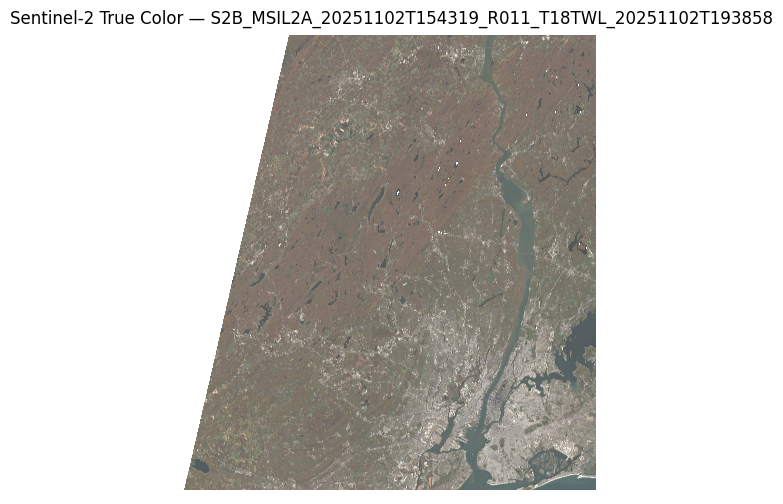

In [ ]:
red_np = stack.sel(band="B04").data.compute().astype(np.float32)
green_np = stack.sel(band="B03").data.compute().astype(np.float32)
blue_np = stack.sel(band="B02").data.compute().astype(np.float32)

rgb_np = np.stack([red_np, green_np, blue_np], axis=0)
stretch = np.nanpercentile(rgb_np, 99)
rgb_np = np.clip(rgb_np / stretch, 0, 1)
rgb_img = np.moveaxis(rgb_np, 0, -1)

plt.figure(figsize=(6, 6))
plt.imshow(rgb_img)
plt.title(f"Sentinel-2 True Color for {tile_id}")
plt.axis("off")
plt.show()

### 5. Engineer Features on the GPU and Run Inference

Compute the same band stack, NDVI, and NDWI features the model saw during training, flatten them to per-pixel rows, and drop any null values before prediction. Run these cells to convert the Sentinel tile into a cuDF table, call `rf.predict`, and inspect the label counts. The output shows the model heavily favors classes 7, 2, and 11, exactly the bias learned from the training AOI. 

In [8]:
b02 = cp.asarray(stack.sel(band="B02").data)
b03 = cp.asarray(stack.sel(band="B03").data)
b04 = cp.asarray(stack.sel(band="B04").data)
b08 = cp.asarray(stack.sel(band="B08").data)

ndvi = (b08 - b04) / (b08 + b04)
ndwi = (b03 - b08) / (b03 + b08)

y_coords = stack.y.values
x_coords = stack.x.values

feature_stack = cp.stack([b02, b03, b04, b08, ndvi, ndwi], axis=0)
flat = feature_stack.reshape(len(ALL_FEATURES), -1).T
mask = cp.isfinite(flat).all(axis=1)

flat_valid = flat[mask]

In [9]:
features_df = cudf.DataFrame(flat_valid, columns=ALL_FEATURES)
preds = rf.predict(features_df)
preds

0           1
1           7
2           7
3           7
4           7
           ..
95085499    1
95085500    1
95085501    1
95085502    1
95085503    1
Length: 95085504, dtype: int32

In [10]:
preds.value_counts()

7     64548701
2     13544566
11     9052580
1      7939651
4            6
Name: count, dtype: int64

### 6. Reshape Predictions Back to the Tile Grid

Restore the flat predictions to their native image layout so you can visualize and export them. This cell fills a nodata-initialized array, drops the predictions into the valid-pixel slots, reshapes everything to the tile’s `y×x` grid, and wraps the result in an `xarray.DataArray` with coordinates and metadata (tile ID, model name, acquisition datetime). Upon running it, the returned `pred_da` matches the raster geometry needed for plotting and COG creation.

In [11]:
full = cp.full(mask.shape[0], NODATA_VALUE, dtype=cp.int16)
full[mask] = preds.astype(cp.int16)

h, w = len(y_coords), len(x_coords)
grid = full.reshape(h, w)

pred_da = xr.DataArray(
    cp.asnumpy(grid),
    coords={"y": y_coords, "x": x_coords},
    dims=("y", "x"),
    name="worldcover_prediction",
).where(cp.asnumpy(mask.reshape(h, w)))

pred_da.attrs.update(
    {
        "tile_id": item.id,
        "model": MODEL_PATH.name,
        "datetime": item.properties["datetime"],
    }
)
pred_da

<xarray.DataArray 'worldcover_prediction' (y: 11118, x: 10150)> Size: 451MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(11118, 10150), dtype=float32)
Coordinates:
  * y        (y) float64 89kB 4.601e+06 4.601e+06 ... 4.489e+06 4.489e+06
  * x        (x) float64 81kB 5.099e+05 5.1e+05 5.1e+05 ... 6.114e+05 6.114e+05
Attributes:
    tile_id:   S2B_MSIL2A_20251102T154319_R011_T18TWL_20251102T193858
    model:     lulc_rf_2022.tl
    datetime:  2025-11-02T15:43:19.024000Z

### 7. Compare the True-Color Tile with Model Predictions

Plot the Sentinel-2 RGB composite alongside the inferred land-cover map to sanity-check the output. Run this cell to render both views with matching coordinates and a legend keyed to the WorldCover classes. Use the side-by-side comparison to see where the classifier follows the imagery and where it inherits the training bias. Urban areas (class 7) dominate, while scarcely sampled categories remain rare.

However, notice that the trained LULC classification model did a good job in distinguishing water and vegetation classes from built area.

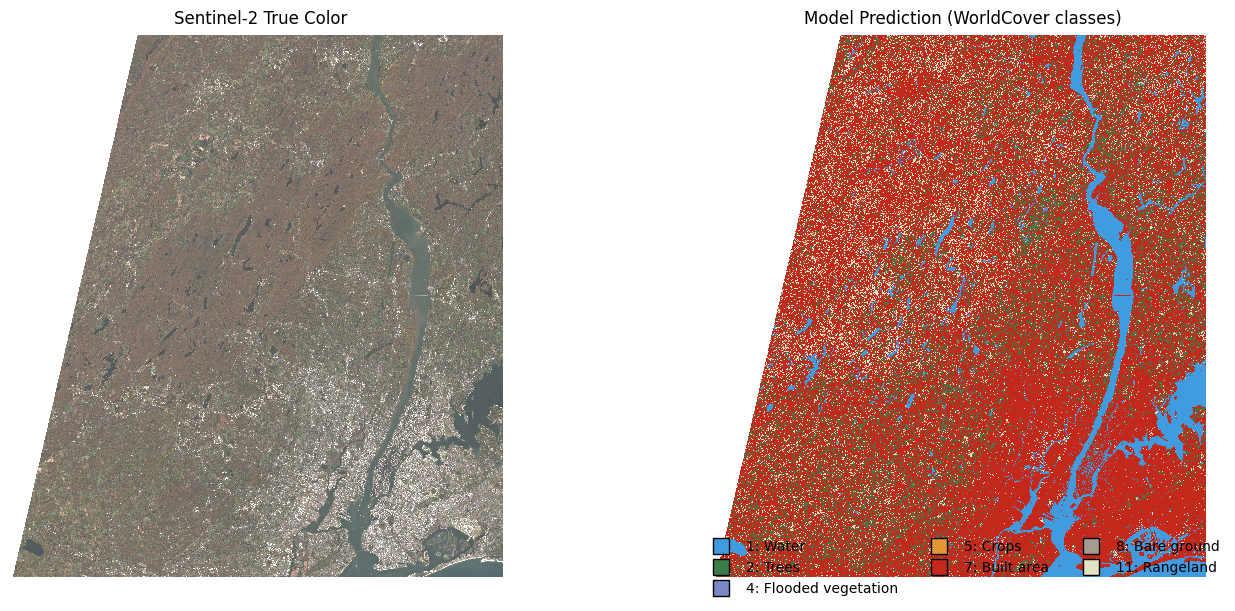

In [ ]:
# Build an RGB DataArray using the tile’s coordinates
rgb_da = xr.DataArray(
    rgb_img,
    dims=("y", "x", "band"),
    coords={"y": stack.y.values, "x": stack.x.values, "band": ["R", "G", "B"]},
)

worldcover_colors = {
    1: "#419bdf",
    2: "#397d49",
    4: "#7a87c6",
    5: "#e49635",
    7: "#c4281b",
    8: "#a59b8f",
    11: "#e3e2c3",
}
classes = list(worldcover_colors.keys())
cmap = ListedColormap([worldcover_colors[i] for i in classes])
norm = BoundaryNorm(classes + [classes[-1] + 1], cmap.N)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Left: true-color tile (coordinates from stack)
rgb_da.plot.imshow(
    ax=axes[0],
    rgb="band",
    add_colorbar=False,
)
axes[0].set_title("Sentinel-2 True Color")
axes[0].set_aspect("equal")
axes[0].axis("off")

# Right: predicted classes
pred_da.plot.imshow(
    ax=axes[1],
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
)
axes[1].set_title("Model Prediction (WorldCover classes)")
axes[1].set_aspect("equal")
axes[1].axis("off")

legend_handles = [
    plt.Line2D(
        [0],
        [0],
        marker="s",
        color="none",
        markerfacecolor=worldcover_colors[c],
        markersize=12,
        linestyle="",
        label=f"{c}: {worldcover_classes[c]}",
    )
    for c in classes
]
axes[1].legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    frameon=False,
)

plt.show()

### 8. Export Predictions as a Cloud-Optimized GeoTIFF

Write the labeled raster to disk so you can share or publish the map. This cell stamps CRS and transform metadata on `pred_da`, writes a temporary GeoTIFF, and uses `cog_translate` to produce the final COG either locally or directly to S3 (toggle `UPLOAD_TO_S3` as needed). Run it to generate the `lulc_<tile_id>.tif` output; the temporary file is removed automatically when saving locally.

In [17]:
INFERENCE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
temp_tif = cog_path.with_suffix(".tmp.tif")

pred_da.rio.write_crs(stack.rio.crs, inplace=True)
pred_da.rio.write_transform(stack.rio.transform(), inplace=True)
pred_da.rio.to_raster(temp_tif, dtype="int16")

if UPLOAD_TO_S3:
    s3_vsis = f"/vsis3/{S3_BUCKET}/{S3_PREFIX.rstrip('/')}/{cog_path.name}"
    cog_translate(temp_tif, s3_vsis, COG_PROFILE, in_memory=False, quiet=False)
else:
    cog_translate(temp_tif, cog_path, COG_PROFILE, in_memory=False, quiet=False)
    temp_tif.unlink(missing_ok=True)
    print("Saved COG:", cog_path)

/raid/jjayabaskar/gis12/lib/python3.12/site-packages/rioxarray/raster_writer.py:301: RuntimeWarning: invalid value encountered in cast
  data = encode_cf_variable(out_data.variable).values.astype(
Reading input: /raid/jjayabaskar/full-outputs/inference/lulc_S2B_MSIL2A_20251102T154319_R011_T18TWL_20251102T193858.tmp.tif

Adding overviews...
Updating dataset tags...
Writing output to: /raid/jjayabaskar/full-outputs/inference/lulc_S2B_MSIL2A_20251102T154319_R011_T18TWL_20251102T193858.tif


Saved COG: /raid/jjayabaskar/full-outputs/inference/lulc_S2B_MSIL2A_20251102T154319_R011_T18TWL_20251102T193858.tif


## Summary 
We have successfully built a end-to-end ML workflow on Sentinel‑2 and ESA WorldCover imagery from acquisition to generating a LULC classification map on an unseen tile, with all processing occurring exclusively on the GPU. We also touched upon a host of libraries within the RAPIDS ecosystem, with the workflow streaming scenes into the GPU using Dask, cleaning and compositing them with Dask and CuPy backed xarray, training a cuML random forest model, and generating predictions into a Cloud-Optimized GeoTIFF. This shows how the RAPIDS ecosystem can accelerate all aspects of a typical ML workflow including geospatial preprocessing, model training, and inference.

## Future Steps  
If you are interested in going further, the next step to improve the classification model is to correct the class imbalance that surfaced in evaluation and inference. This can be done by expanding the AOI, adding more tiles or seasons, or stratify sampling so that crops, flooded vegetation, and bare ground gain enough pixels. Re-run the GPU pipeline on that richer dataset, track the class histograms, and confirm the confusion matrix closes the gap.